# Data exploration




In [227]:
import multiresolutionimageinterface as mri
import pandas as pd
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
import getpass  # get user name
%matplotlib inline
from sklearn.utils import shuffle
from tqdm import tqdm

In [228]:
username = getpass.getuser()
username = 'Chensey'
print(f'Working directory: {username}')

if  username == 'Gabriel Raya':
    # project and data directories
    root_dir=  r'E:\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction'
    data_dir = r'E:\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\data'

    # wsi directories
    dir_luad_wsi = os.path.join(data_dir, 'tcga_luad', 'wsi_diagnostic_tif')
    dir_lusc_wsi = os.path.join(data_dir, 'tcga_lusc', 'wsi_diagnostic_tif')
    dir_luad_wsi_mask = os.path.join(data_dir, 'tcga_luad', 'tissue_masks_diagnostic')
    dir_lusc_wsi_mask = os.path.join(data_dir, 'tcga_lusc', 'tissue_masks_diagnostic')
    
    # Set paths
    model_path = './neural-image-compression-private/models/encoders_patches_pathology/encoder_bigan.h5'
    csv_train = os.path.join(data_dir, 'train_slide_list_tcga.csv')
    csv_val = os.path.join(data_dir, 'validation_slide_list_tcga.csv')
    csv_test = os.path.join(data_dir, 'test_slide_list_tcga.csv')
    
    # results directory 
    result_dir = join(root_dir, 'results', 'models', 'baseline_local')  # store the results from trained model
    
else:
    # Data on chensey
    root_dir=  r'Z:\projects\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction'
    data_dir = r'Z:\archives\lung'
    
    # wsi directories
    dir_luad_wsi = join(data_dir, 'TCGA_LUAD', 'wsi_diagnostic_tif')
    dir_lusc_wsi = join(data_dir, 'TCGA_LUSC', 'wsi_diagnostic_tif')
    dir_luad_wsi_mask = os.path.join(data_dir, 'TCGA_LUAD', 'tissue_masks_diagnostic')
    dir_lusc_wsi_mask = os.path.join(data_dir, 'TCGA_LUSC', 'tissue_masks_diagnostic')
    
    # Set paths
    model_path = './neural-image-compression-private/models/encoders_patches_pathology/encoder_bigan.h5'
    csv_train = os.path.join(root_dir, 'data', 'train_slide_list_tcga.csv')
    csv_val = os.path.join(root_dir, 'data', 'validation_slide_list_tcga.csv')
    csv_test = os.path.join(root_dir, 'data', 'test_slide_list_tcga.csv')
    
    # results directory 
    result_dir = join(root_dir, 'results', 'models', 'baseline_8_100_bigan')  # store the results from trained model
    
# compressed image directories
vectorized_luad_dir = join(root_dir, 'results', 'tcga_luad', 'vectorized')
vectorized_lusc_dir = join(root_dir, 'results', 'tcga_lusc', 'vectorized')
featurized_luad_dir = join(root_dir, 'results', 'tcga_luad', 'featurized', 'no_augmentations')
featurized_lusc_dir = join(root_dir, 'results', 'tcga_lusc', 'featurized', 'no_augmentations')
    
# gradcam directory
gradcam_dir = join(result_dir, 'gradcam')        # store gradcam results

# csv paths
csv_path_wsi =  os.path.join(root_dir,'data/slide_original_list_tcga.csv')

cache_dir = None  # used to store local copies of files during I/O operations (useful in cluster


data = pd.read_csv(csv_train)
print(data['label'].value_counts())
data.head()

Working directory: Chensey
1    531
0    506
Name: label, dtype: int64


slide_id  label
0  TCGA-05-4244-01Z-00-DX1      1
1  TCGA-05-4245-01Z-00-DX1      1
2  TCGA-05-4249-01Z-00-DX1      1
3  TCGA-05-4250-01Z-00-DX1      1
4  TCGA-05-4382-01Z-00-DX1      1

# Data distribution

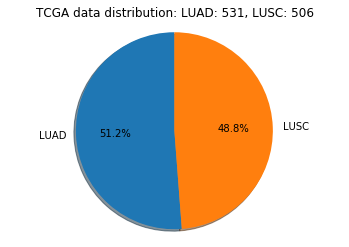

In [78]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = np.unique(data['label'])
#sizes = [np.mean(df.label), 1-np.mean(df.label)]
sizes = data['label'].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=['LUAD','LUSC'], autopct='%1.1f%%',  shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title = f'TCGA data distribution: LUAD: {sizes[1]}, LUSC: {sizes[0]}' )
plt.show()

In [105]:
def get_pixel_lenghts(image_path):
    """
    Reads a complete WSI and returns a the width and height

    returns: image numpy array 
    """
    # Open wsi image
    mr_image = mri.MultiResolutionImageReader().open(image_path)
    # Get Dimensions
    x_dim, y_dim = mr_image.getDimensions()
    return x_dim, y_dim

 
heights = []
widths  = []

# get dimensions for LUSC data
for idx in tqdm(data[data['label'] == 0]['slide_id']):
    path = join(dir_lusc_wsi, idx)
    width, height = get_pixel_lenghts(path + '.tif')
    heights.append(height)
    widths.append(width)

# get dimensions for LUAD data
for idx in tqdm(data[data['label'] == 1]['slide_id']):
    path = join(dir_luad_wsi, idx)
    width, height = get_pixel_lenghts(path + '.tif')
    heights.append(height)
    widths.append(width)
    
print(r'Shapes is {len(heights)}')

100%|██████████| 531/531 [10:25<00:00,  1.18s/it]


Shapes is {len(heights)}


In [113]:
np.unique(heights)

array([ 7522,  7625,  7816, ..., 55424, 55680, 61568])

In [114]:
np.unique(widths)

array([ 7995,  8153,  8964,  9592, 10551, 11031, 11424, 11900, 12470,
       12852, 13328, 13429, 13909, 14388, 14756, 14868, 14940, 15232,
       15347, 15708, 15827, 15936, 15991, 16184, 16307, 16786, 16932,
       17266, 17612, 17746, 17928, 17989, 18225, 18560, 18705, 18924,
       19040, 19184, 19516, 19664, 19988, 19992, 20144, 20352, 20468,
       20623, 20642, 20915, 20916, 20944, 21103, 21120, 21583, 21896,
       21987, 22062, 22372, 22542, 22848, 22907, 23168, 23501, 23522,
       23936, 23981, 23986, 24192, 24460, 24752, 24899, 24900, 24940,
       25216, 25420, 25895, 25896, 25899, 25985, 25998, 26379, 26656,
       26858, 27132, 27338, 27363, 27818, 27887, 27888, 27984, 28297,
       28777, 28884, 29257, 29736, 29880, 29983, 30216, 30695, 30875,
       30876, 31175, 31655, 31744, 31892, 31982, 32000, 32134, 32380,
       32614, 32844, 32867, 32868, 33093, 33280, 33319, 33573, 33796,
       33864, 34053, 34304, 34532, 34860, 35012, 35072, 35224, 35430,
       35492, 35855,

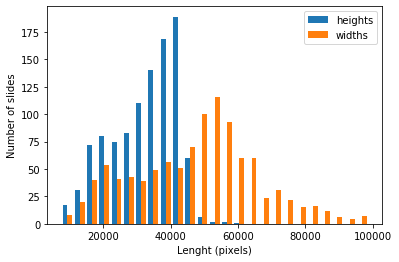

In [126]:
plt.hist([heights, widths], bins= 25)
plt.ylabel('Number of slides')
plt.xlabel('Lenght (pixels)')
plt.legend(['heights', 'widths'])
plt.show()

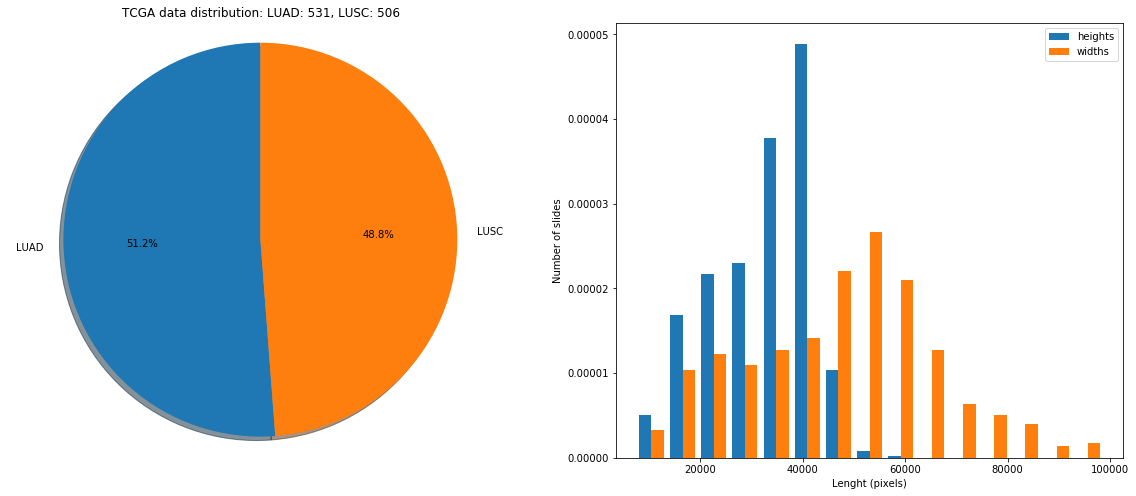

In [175]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = np.unique(data['label'])
#sizes = [np.mean(df.label), 1-np.mean(df.label)]
sizes = data['label'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax0, ax1, = axes.flatten()


ax0.pie(sizes, labels=['LUAD','LUSC'], autopct='%1.1f%%',  shadow=True, startangle=90)
ax0.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax0.set(title = f'TCGA data distribution: LUAD: {sizes[1]}, LUSC: {sizes[0]}' )


colors = ['red', 'tan', 'lime']
ax1.hist([heights, widths],  bins= 15, density=True, histtype='bar')
ax1.legend(['heights', 'widths'])
ax1.set_ylabel('Number of slides')
ax1.set_xlabel('Lenght (pixels)')
plt.show()

In [238]:
path = join(featurized_luad_dir, 'TCGA-05-4250-01Z-00-DX1.npy')
compressed_wsi = np.load(path)
compressed_wsi.shape

TypeError: 'tuple' object is not callable

In [240]:
# Get dimensions for compressed wsis

heights = []
widths  = []
depths  = []

# get dimensions for LUSC data
for filename in tqdm(data[data['label'] == 0]['slide_id']):
    path = join(featurized_lusc_dir, filename)
    compressed_wsi = np.load(path + '.npy')
    height, width, depth = compressed_wsi.shape
    heights.append(height)
    widths.append(width)
    depths.append(depth)

 49%|████▉     | 248/506 [31:31<1:04:58, 15.11s/it]

KeyboardInterrupt: 

In [ ]:


# get dimensions for LUAD data
for idx in tqdm(data[data['label'] == 1]['slide_id']):
    path = join(dir_luad_wsi, idx)
    width, height = get_pixel_lenghts(path + '.tif')
    heights.append(height)
    widths.append(width)
    
print(r'Shapes is {len(heights)}')

In [169]:
from math import ceil
top = ceil(max(np.unique(widths))/10000)*10000

x = range(0, top, top//20)
x

range(0, 100000, 5000)

100000

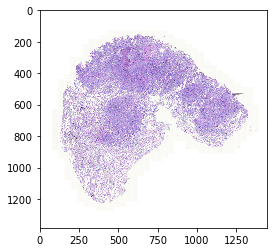

In [85]:
def readImage(image_path, level=4):
    """
    Reads a complete WSI and returns a numpy array 
    In a WSI, at each higher resolution level the size is decreased by half.
    For this reason the dimensions should be decreased by 2^level for a given image resolution level

    returns: image numpy array 
    """
    # Open wsi image
    mr_image = mri.MultiResolutionImageReader().open(image_path)
    # Get Dimensions
    x_dim, y_dim = mr_image.getDimensions()
    # 
    img = mr_image.getUCharPatch(startX=0,startY=0, width=x_dim//2**level, height=y_dim//2**level, level=level)
    
    return img

# plot single image
image_path= join(dir_luad_wsi, 'TCGA-05-4244-01Z-00-DX1.tif')
img = readImage(image_path, level=4)
plt.imshow(img)

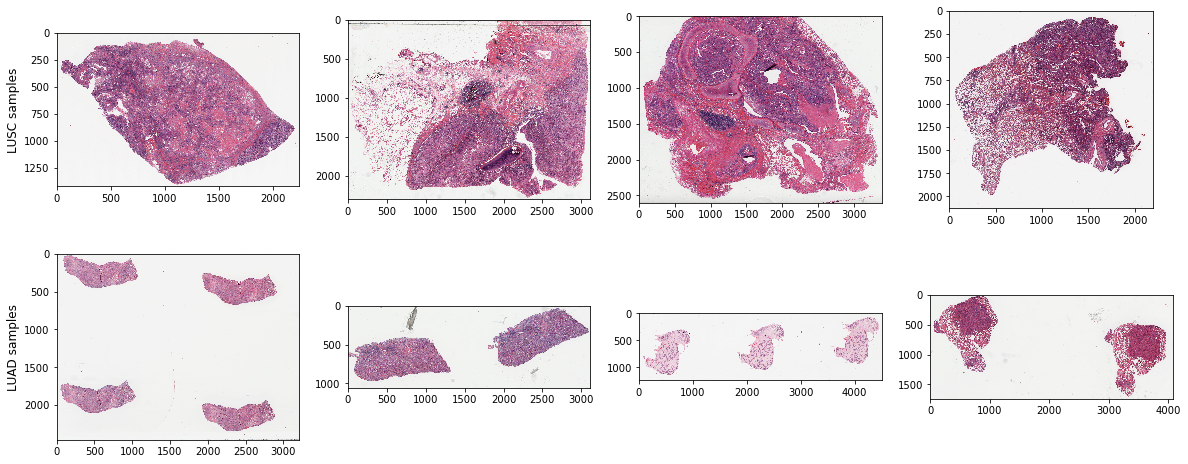

In [183]:


columns = 4

def get_sample_data(data, columns):
    fig, ax = plt.subplots(2,columns, figsize=(20,8))
    # fig.suptitle('Lung Cancer Whole Slide Images',fontsize=20)
    # Negatives
    # random sampling
    shuffled_data = shuffle(data)
    
    for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['slide_id'][:columns]):
        path = join(dir_lusc_wsi, idx)
        ax[0,i].imshow(readImage(path + '.tif'))
    ax[0,0].set_ylabel('LUSC samples', size='large')

    for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['slide_id'][:columns]):
        path = join(dir_luad_wsi, idx)
        ax[1,i].imshow(readImage(path + '.tif'))
    ax[1,0].set_ylabel('LUAD samples', size='large')
    
get_sample_data(data, columns)

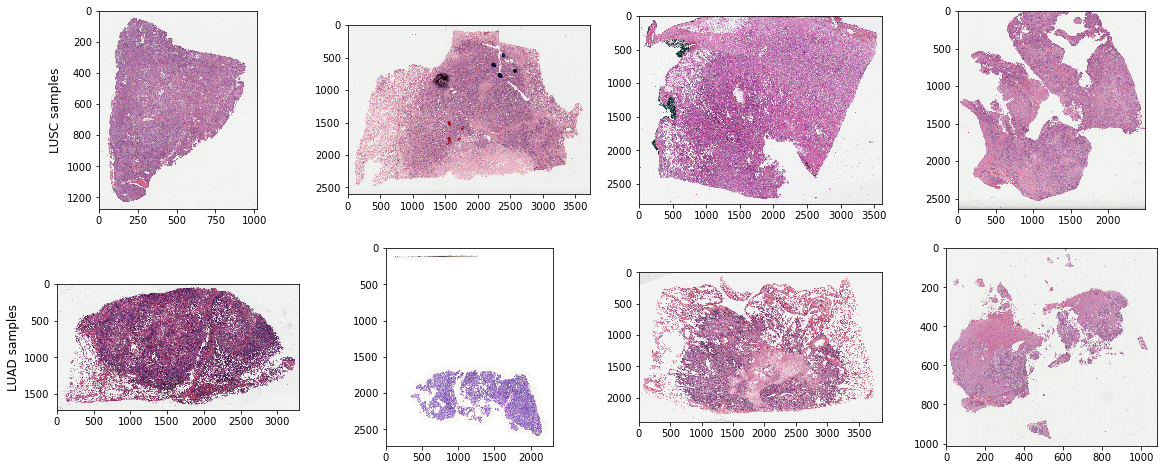

In [182]:
# get another samples
get_sample_data(data, columns)

In [185]:
def get_features(path):
    """return a feature from compressed wsi np array"""
    features = np.load(path + '.npy')
    features = (255*(features - np.min(features))/np.ptp(features)).astype(int)
    return features

Text(0, 0.5, 'LUSC compression')

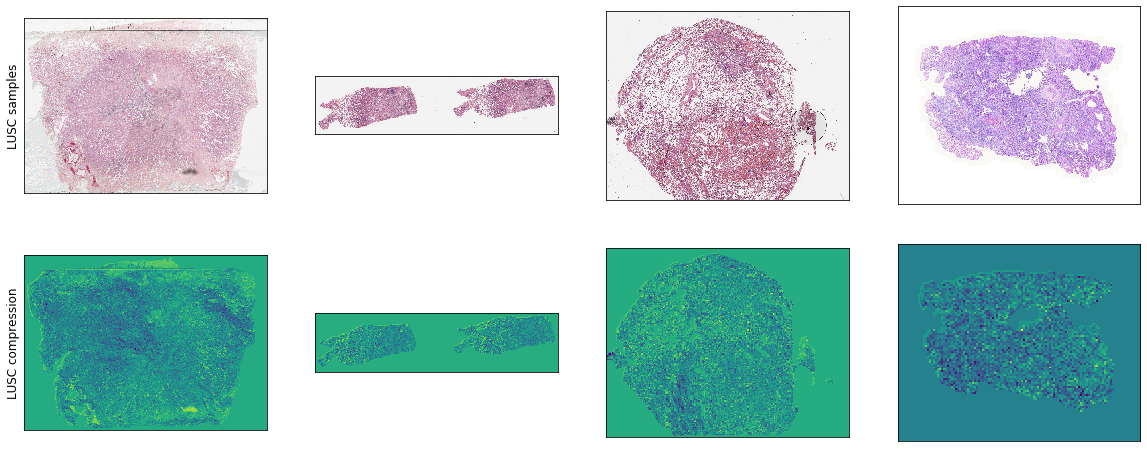

In [207]:
# random sampling
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,4, figsize=(20,8))
# fig.suptitle('Whole Slide Images Compressed using NIC',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['slide_id'][:4]):
    path = join(dir_luad_wsi, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[0,i].set_aspect('equal')
    path = join(featurized_luad_dir, idx)
    features = get_features(path)
    # plot 1 feautre out of 128
    ax[1,i].imshow(features[0])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[1,i].set_aspect('equal')
ax[0,0].set_ylabel('LUSC samples', size='large')
ax[1,0].set_ylabel('LUSC compression', size='large')

<Figure size 1440x576 with 0 Axes>

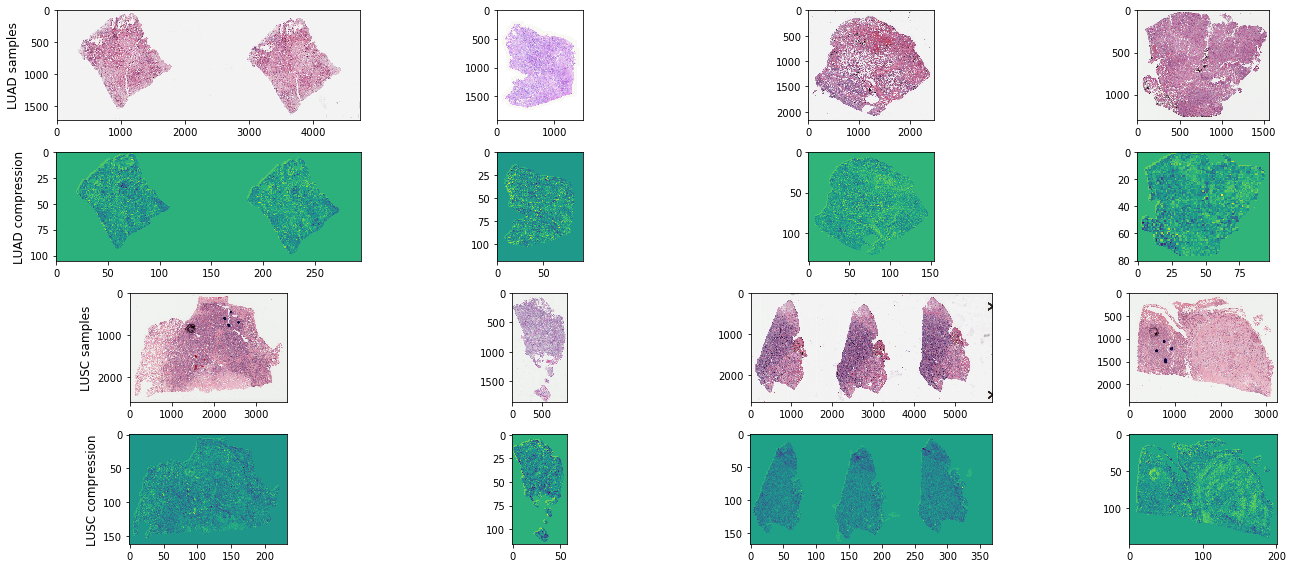

In [214]:
import matplotlib.gridspec as gridspec


def get_sample_compressed_data(columns=4):  
    # random sampling
    shuffled_data = shuffle(data)
    

    plt.figure(figsize=(20,8))
    gs1 = gridspec.GridSpec(20,8)
    gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

    fig, ax = plt.subplots(4,columns, figsize=(20,8))
#     fig.suptitle('Lung Cancer Whole Slide Images',fontsize=20)
    # LUAD
    for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['slide_id'][:columns]):
        path = join(dir_luad_wsi, idx)
        ax[0,i].imshow(readImage(path + '.tif'))
#         ax[0,i].set_aspect('equal')
        path = join(featurized_luad_dir, idx)
        features = get_features(path)
        # plot 1 feautre out of 128
        ax[1,i].imshow(features[0])
#         ax[1,i].set_aspect('equal')
    ax[0,0].set_ylabel('LUAD samples', size='large')
    ax[1,0].set_ylabel('LUAD compression', size='large')
    
    # LUSC
    for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['slide_id'][:columns]):
        path = join(dir_lusc_wsi, idx)
        ax[2,i].imshow(readImage(path + '.tif'))
#         ax[2,i].set_aspect('equal')
        path = join(featurized_lusc_dir, idx)
        features = get_features(path)
        # plot 1 feautre out of 128
        ax[3,i].imshow(features[0])
#         ax[3,i].set_aspect('equal')
    ax[2,0].set_ylabel('LUSC samples', size='large')
    ax[3,0].set_ylabel('LUSC compression', size='large')
    
    plt.subplots_adjust(wspace=0, hspace=0)
get_sample_compressed_data()
plt.tight_layout()

<Figure size 288x288 with 0 Axes>

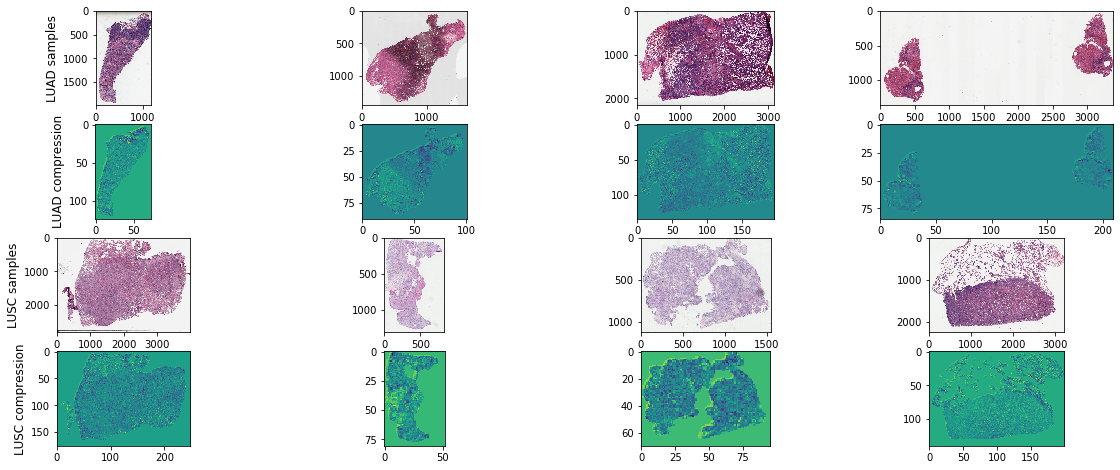

In [212]:
get_sample_compressed_data(4)

In [225]:
def plot_gradcam(gradcam_images):
    %matplotlib inline
    rows = 2; columns = 6;
    fig, axs = plt.subplots(rows,columns,figsize=(20,8))
    axs = axs.ravel()
    n_images = rows * columns
#     fig.suptitle('GradCam Analysis',fontsize=20)
    for idx in range(n_images):
        img = plt.imread(gradcam_images[idx])
        if idx == 0: print(f'Images shape: {img.shape}')
        axs[idx].imshow(img[120:280,120:280])
        prefix = os.path.basename(gradcam_images[idx]).split('_')[0]
        subfix = os.path.basename(gradcam_images[idx]).split('_')[-1]
        axs[idx].set_title(prefix + '_' + subfix)
        axs[idx].set_xlabel(prefix + subfix)
        axs[idx].get_xaxis().set_visible(False)
        axs[idx].get_yaxis().set_visible(False)

Images shape: (400, 400, 4)


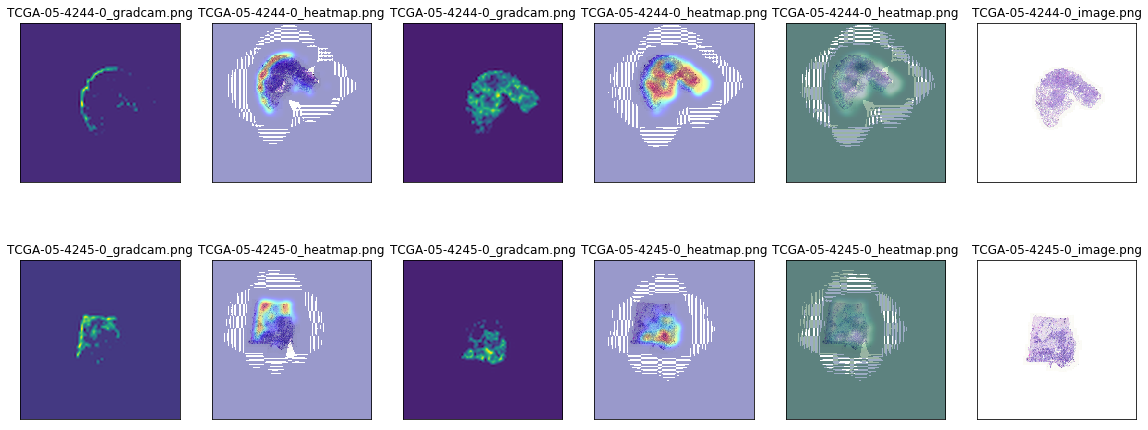

In [226]:
# Get gradcam images
gradcam_images = sorted([os.path.join(gradcam_dir, f) for f in os.listdir(gradcam_dir) if f.endswith('.png')])

# Plot images
plot_gradcam(gradcam_images)

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Whole Slide Images Compressed using NIC',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['slide_id'][:5]):
    path = join(gradcam_dir, idx)
    ax[0,i].imshow(readImage(path + '_gradcam.png'))
    path = join(featurized_luad_dir, idx)
    features = get_features(path)
    # plot 1 feautre out of 128
    ax[1,i].imshow(features[0])
ax[0,0].set_ylabel('LUSC samples', size='large')
ax[1,0].set_ylabel('LUSC compression', size='large')


In [13]:


data_dir = r'Z:\projects\pathology-lung-cancer-weak-growth-pattern-prediction/results/tcga'
csv_path = r'Z:\projects\pathology-lung-cancer-weak-growth-pattern-prediction/data/tcga/slide_list_cga.csv'
output_dir = r'Z:\projects\pathology-lung-cancer-weak-growth-pattern-prediction/results/tcga/model'

In [14]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [16]:
label_dict_path = r'Z:\projects\pathology-lung-cancer-weak-growth-pattern-prediction/data/tcga/label_dict.pkl'

try:
    with open(label_dict_path, 'rb') as label_dict_file:
        label_dict = pickle.load(label_dict_file)
except:
    label_file_path = os.path.join(os.path.join(data_dir), 'slide_list_cga.csv')
    label_dict = {row[0]: row[1] for _, row in pd.read_csv(label_file_path).iterrows()}
    with open(label_dict_path, 'wb') as label_dict_file:
        pickle.dump(label_dict, label_dict_file)

In [17]:
class Dataset(torch.utils.data.Dataset):
    """
    Returns a sample of the data
    """
    def __init__(self, dir, file_names, preview=False):
        self.dir = dir
        self.file_names = file_names
        self.preview = preview
        
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        image = np.load(os.path.join(self.dir, file_name))
        if self.preview:
            image = (255*(image - np.min(image))/np.ptp(image)).astype(int) 
        label = label_dict[file_name.replace('.npy', '')]
        return image, label        

    def __len__(self):
        return len(self.file_names)

    @property
    def labels(self):
        return np.array([label_dict[file_name.replace('.npy', '')] for file_name in self.file_names])


In [19]:
# get all file names
image_dir = os.path.realpath(data_dir + r'\featurized\tcga_luad\normal')
all_file_names = [file for file in os.listdir(image_dir) if file.split('_')[0].endswith('.npy')]

In [21]:
# Split data
split_factor = 0.2
valid_samples = round(len(all_file_names)*split_factor)

train_file_names = all_file_names[:-valid_samples]
valid_file_names = all_file_names[len(train_file_names):]

preview = Dataset(image_dir, all_file_names[:4], preview=True)
train = Dataset(image_dir, train_file_names)
valid = Dataset(image_dir, valid_file_names)

train_loader = torch.utils.data.DataLoader(train, 32, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid, 32, shuffle=True, num_workers=2)

In [23]:
# Import Data
featurized_dir = r'Z:\projects\pathology-lung-cancer-weak-growth-pattern-prediction\results\tcga\featurized\tcga_luad\normal'
featurized_list = os.listdir(featurized_dir)

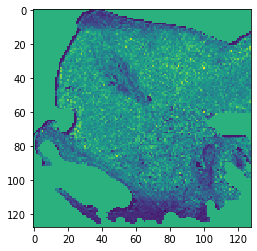

In [24]:
label_names = ['LUSC', 'LUAD']
image, label = preview.__getitem__(0)
sample_image = image[125]
plt.imshow(sample_image[:128, :128])
plt.show()

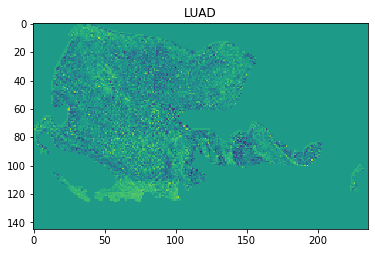

Image shape: (128, 145, 236)
Min value: 0, max value: 255


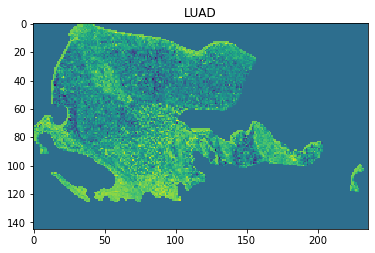

Image shape: (128, 145, 236)
Min value: 0, max value: 255


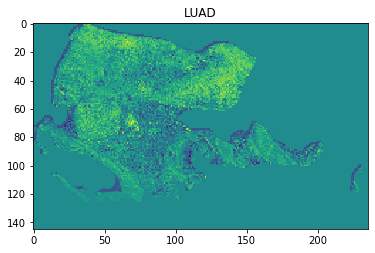

Image shape: (128, 145, 236)
Min value: 0, max value: 255


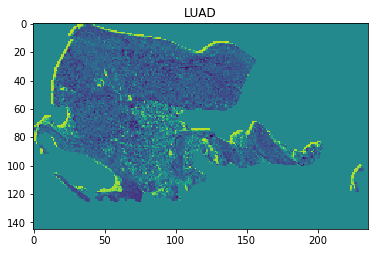

Image shape: (128, 145, 236)
Min value: 0, max value: 255


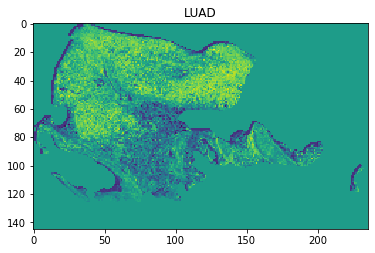

Image shape: (128, 145, 236)
Min value: 0, max value: 255


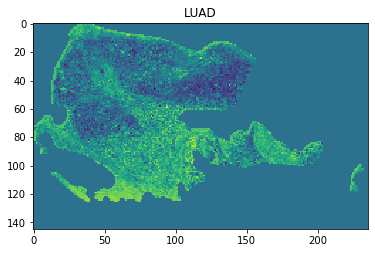

Image shape: (128, 145, 236)
Min value: 0, max value: 255


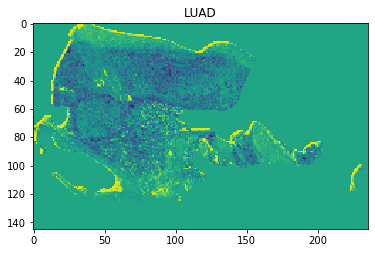

Image shape: (128, 145, 236)
Min value: 0, max value: 255


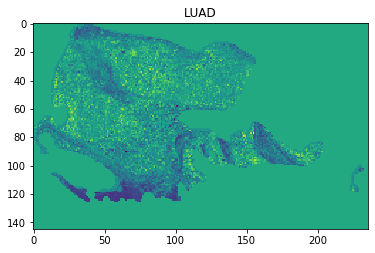

Image shape: (128, 145, 236)
Min value: 0, max value: 255


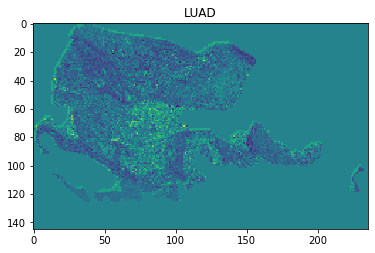

Image shape: (128, 145, 236)
Min value: 0, max value: 255


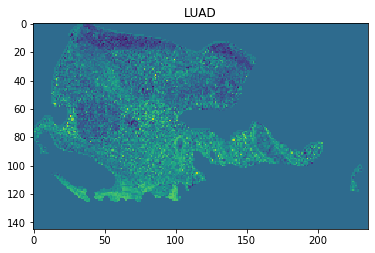

Image shape: (128, 145, 236)
Min value: 0, max value: 255


In [88]:
for idx in range(len(image[:10])):
    plt.title(label_names[label])
    plt.imshow(image[idx])
    plt.show()
    print(f'Image shape: {image.shape}')
    print(f'Min value: {image.min()}, max value: {image.max()}')

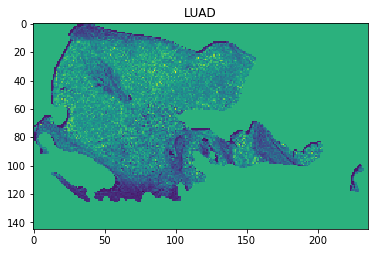

Image shape: (128, 145, 236)
Min value: 0, max value: 255


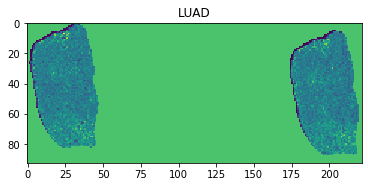

Image shape: (128, 93, 222)
Min value: 0, max value: 255


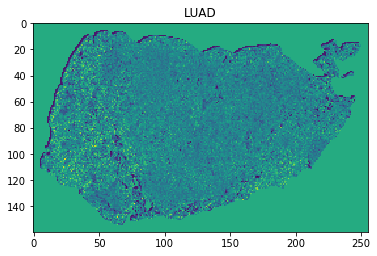

Image shape: (128, 160, 256)
Min value: 0, max value: 255


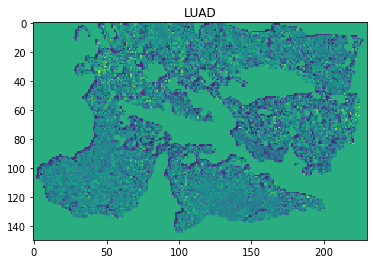

Image shape: (128, 150, 230)
Min value: 0, max value: 255


In [82]:
for image, label in preview:
    plt.title(label_names[label])
    slide = image[125]
    plt.imshow(slide)
    plt.show()
    print(f'Image shape: {image.shape}')
    print(f'Min value: {image.min()}, max value: {image.max()}')